In [1]:
# standard libs
import os
import sys
import logging

# project lib
PROJECT_SRC_PATH = os.path.join(os.path.abspath(''), '..', 'src')
sys.path.append(PROJECT_SRC_PATH)

import utils
import dataset
import visualizations
import geometry
from prediction_age import AgePredictor, AgeClassifier, AgeClassifierComparison
from preprocessing import *
from preparation import *

# external libs
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import geopandas as gpd
from shapely import wkt

import shap

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostClassifier
from xgboost import XGBRegressor, XGBClassifier, XGBRFClassifier

/usr/local/Caskroom/miniconda/base/envs/uf-ml/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s', level=logging.INFO)

In [4]:
%load_ext autoreload
%autoreload 2

## Data

In [5]:
path_data_france = os.path.join('..', 'data', 'france-cities-200.csv')
data_france = pd.read_csv(path_data_france)

In [5]:
path_data_netherlands = os.path.join('..', 'data', 'netherlands-cities-200.csv')
data_netherlands = pd.read_csv(path_data_netherlands)

In [5]:
gdf_nl = utils.load_data('netherlands', geo=True)
gdf_nl_sample = utils.sample_cities(gdf_nl, 0.1)


## Cleaning

In [ ]:
# merges overlapping street polygons and removes duplicates
sbb_gdf = geometry.prepare_street_polygons()
gdf_path = os.path.join'(..', 'data', f'sbb-{"-".join(abbr)}.pkl')
sbb_gdf.to_pickle(gdf_path)


## Preprocessing

In [6]:
df = utils.sample_cities(gdf_nl, 0.1)
df = add_block_building_ids_column(df)
df = add_sbb_building_ids_column(df)
df = add_neighborhood_column(df)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

2022-05-16 14:56:07,348 | INFO : On average 7 street blocks have been assigned per neighborbood cluster.

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

In [162]:
# file_gadm = os.path.join(geometry.DATA_DIR, 'gadm_table.csv')
# gadm_info = pd.read_csv(file_gadm)
# crs = gadm_info[gadm_info['country_name'] == 'netherlands']['local_crs'].values
# crs
# geo = geometry.load_building_geometry(countries=['france'])
geo

geopandas.geodataframe.GeoDataFrame

In [ ]:
import glob
files_sbb = glob.glob('../data/sbb/*_sbb.csv')
data_sbb = pd.concat((pd.read_csv(f) for f in files_sbb), ignore_index=True)
data_sbb.to_csv('netherlands_sbb.csv', encoding='utf-8', index=False)

In [51]:
# data_netherlands_sample = data_netherlands.sample(frac=.1, random_state=dataset.GLOBAL_REPRODUCIBILITY_SEED)
data_netherlands_sample =  add_street_block_column(data_netherlands)

2022-03-08 15:00:38,807 | WARNING : Spatial joining resulted in duplicate buildings in dataset. Most likely street polygons were overlapping and buildings were assigned to more than one during gpd.sjoin().
2022-03-08 15:00:38,810 | INFO : Removing duplicated buildings, keeping only first one.


In [ ]:
# data_france_sample = data_france.sample(frac=.1, random_state=dataset.GLOBAL_REPRODUCIBILITY_SEED)
data_france_sample = add_street_block_column(data_france)

In [61]:
ratio = len(data_france_sample) / len(data_netherlands_sample)

data_france_sized_sample = data_france_sample
data_netherlands_sized_sample = data_netherlands_sample.sample(frac=ratio, random_state=dataset.GLOBAL_REPRODUCIBILITY_SEED)
data_baseline_sample = pd.concat([data_france_sized_sample, data_netherlands_sized_sample]).sample(frac=.5, random_state=dataset.GLOBAL_REPRODUCIBILITY_SEED)

assert len(data_netherlands_sized_sample) == len(data_france_sized_sample) == len(data_baseline_sample)

print(f'Dataset used for experiments has {len(data_france_sized_sample)} buildings.')

Dataset used for experiments has 108016 buildings.


## Impact on prediction performance

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


MAE: 17.40 y
RMSE: 22.86 y
R2: 0.2242


invalid value encountered in true_divide


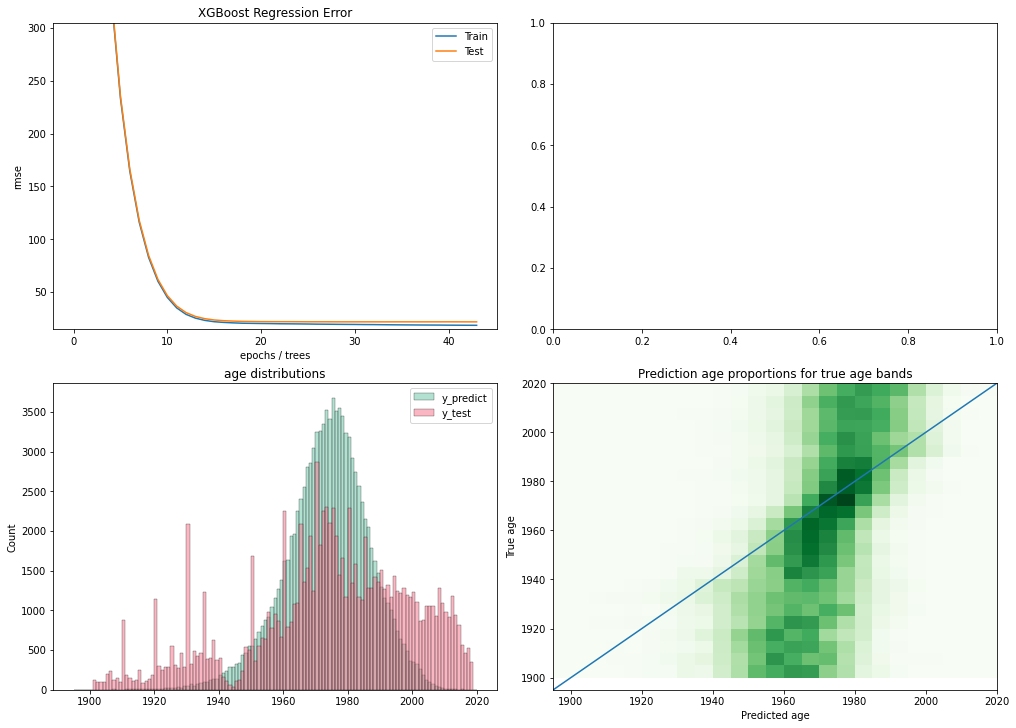

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


<Figure size 432x288 with 0 Axes>

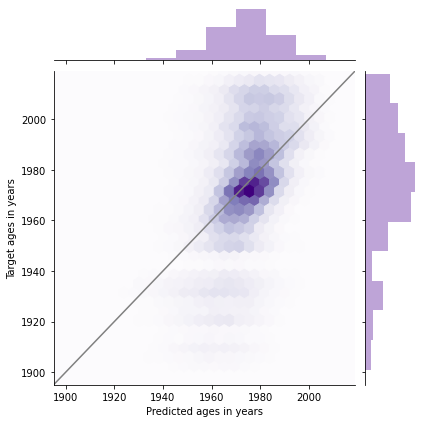

In [108]:
predictor = AgePredictor(
    model=XGBRegressor(),
    df=data_netherlands_sized_sample,
    cross_validation_split=city_cross_validation,
    preprocessing_stages=[remove_outliers]
)
predictor.evaluate_regression()

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated an

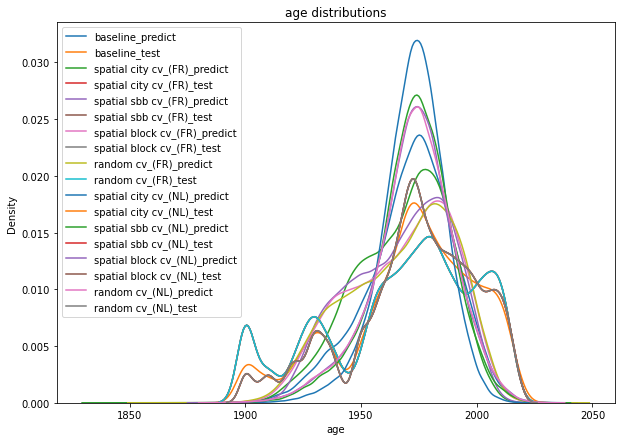

,name,R2,MAE,RMSE
5,spatial city cv_(NL),0.237275,18.006950,23.705682
1,spatial city cv_(FR),0.338974,19.738951,26.058962
6,spatial sbb cv_(NL),0.363661,15.656800,21.652739
7,spatial block cv_(NL),0.406998,14.813050,20.902416
2,spatial sbb cv_(FR),0.413472,18.278858,24.546637
0,baseline,0.417832,15.659506,21.745340
8,random cv_(NL),0.422552,14.569714,20.626475
3,spatial block cv_(FR),0.467767,16.882583,23.382922
4,random cv_(FR),0.482942,16.581455,23.047160


In [62]:
logging.disable(logging.WARN)

# data_france_sample = data_france.sample(frac=.1, random_state=dataset.GLOBAL_REPRODUCIBILITY_SEED)
# data_france_sample = data_france[data_france['id'].isin(add_street_block_column(data_france)['id'])]

grid_comparison_config = {
    '(FR)': {'df': data_france_sized_sample},
    '(NL)': {'df': data_netherlands_sized_sample},
}
comparison_config = {
    'spatial city cv': {'cross_validation_split': city_cross_validation, 'test_training_split': None},
    'spatial sbb cv': {'cross_validation_split': sbb_cross_validation, 'test_training_split': None},
    'spatial block cv': {'cross_validation_split': block_cross_validation, 'test_training_split': None},
    'random cv': {'cross_validation_split': cross_validation, 'test_training_split': None},
}


comparison = AgePredictorComparison(
    model=XGBRegressor(),
    df=data_baseline_sample,
    test_training_split=split_80_20,
    preprocessing_stages=[remove_buildings_pre_1900],
    comparison_config=comparison_config,
    grid_comparison_config=grid_comparison_config,
)

comparison_results = comparison.evaluate_comparison()
comparison_results

2022-03-08 16:33:57,079 | INFO : Generated bins: [0, 1915, 1945, 1965, 1980, 2000, inf]
2022-03-08 16:33:57,080 | INFO : Generated bins with the following labels: ['<1915', '1915-1944', '1945-1964', '1965-1979', '1980-1999', '>=2000']
2022-03-08 16:33:57,096 | INFO : Dataset length: 8246
2022-03-08 16:33:57,097 | INFO : Reusing street-based block (sbb) column existing in data.
2022-03-08 16:33:57,120 | INFO : Training dataset length: 6596
2022-03-08 16:33:57,121 | INFO : Test dataset length: 1650
2022-03-08 16:33:57,137 | INFO : age attribute has been categorized (lowest age included: 0; highest age included: inf; other buildings have been removed).
2022-03-08 16:33:57,142 | INFO : age attribute has been categorized (lowest age included: 0; highest age included: inf; other buildings have been removed).
2022-03-08 16:33:57,156 | INFO : Training dataset length after preprocessing: 6418
2022-03-08 16:33:57,157 | INFO : Test dataset length after preprocessing: 1614
pandas.Int64Index is dep

              precision    recall  f1-score   support

       <1915       0.26      0.26      0.26       307
   1915-1944       0.39      0.48      0.43       931
   1945-1964       0.49      0.50      0.49      1245
   1965-1979       0.64      0.56      0.60      2137
   1980-1999       0.57      0.54      0.56      2066
      >=2000       0.43      0.48      0.45      1346

    accuracy                           0.51      8032
   macro avg       0.46      0.47      0.46      8032
weighted avg       0.52      0.51      0.51      8032

Cohen’s kappa: 0.3901366694678682
Matthews correlation coefficient (MCC): 0.3907541248964409


FixedFormatter should only be used together with FixedLocator


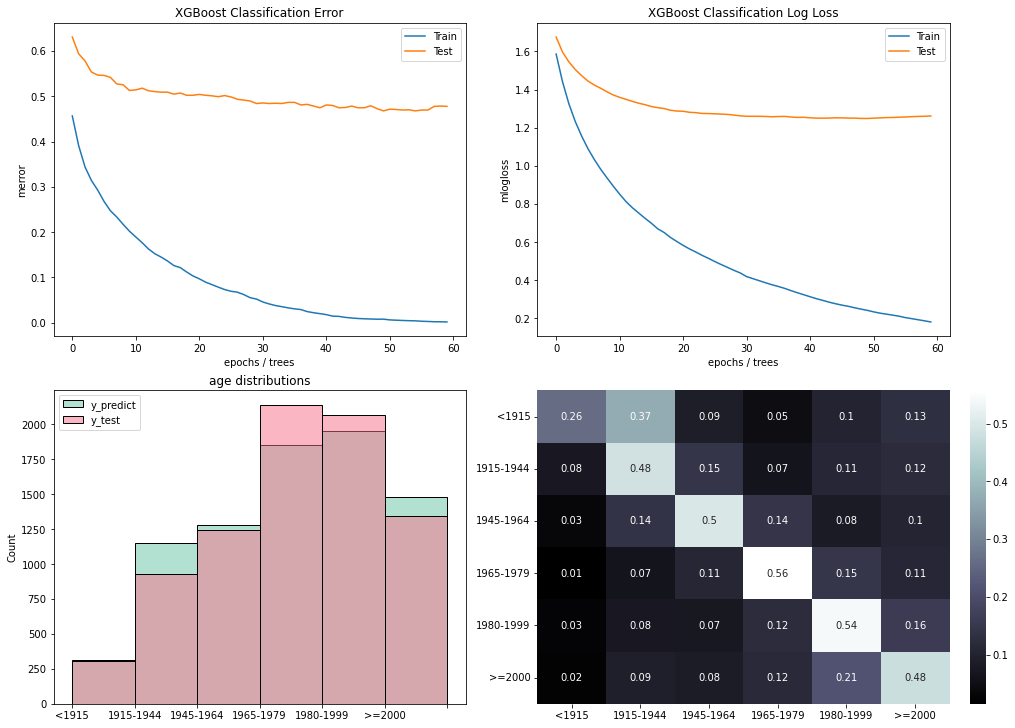

In [72]:
classifier_nl_native = AgeClassifier(
    model=XGBClassifier(),
    df=data_netherlands_sample.sample(frac=.01),
    cross_validation_split=sbb_cross_validation,
    preprocessing_stages=[remove_buildings_pre_1900],
    predict_probabilities=False,
    mitigate_class_imbalance=True,
    bins=dataset.EHS_AGE_BINS,
)
classifier_nl_native.evaluate_classification()

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.I

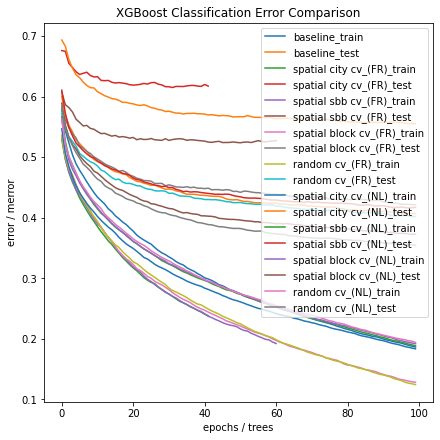

,name,MCC,F1,Recall_<1915,Recall_1915-1944,Recall_1945-1964,Recall_1965-1979,Recall_1980-1999,Recall_>=2000
1,spatial city cv_(FR),0.250418,0.378643,0.437803,0.364016,0.302071,0.356169,0.387687,0.453385
5,spatial city cv_(NL),0.293451,0.393800,0.343963,0.351457,0.423118,0.471481,0.409603,0.455910
2,spatial sbb cv_(FR),0.356327,0.463091,0.559889,0.481994,0.429661,0.423816,0.450268,0.500703
6,spatial sbb cv_(NL),0.483291,0.536982,0.472736,0.578044,0.560114,0.608557,0.587461,0.560307
3,spatial block cv_(FR),0.483864,0.563041,0.586661,0.571305,0.518268,0.540964,0.589018,0.623565
0,baseline,0.503448,0.562338,0.512758,0.572170,0.565179,0.611241,0.609278,0.608609
4,random cv_(FR),0.507598,0.581995,0.593815,0.592048,0.536680,0.558681,0.612867,0.647341
7,spatial block cv_(NL),0.549444,0.587461,0.535540,0.615569,0.614100,0.663917,0.643522,0.616978
8,random cv_(NL),0.564113,0.599724,0.554528,0.626986,0.631566,0.675881,0.651350,0.628751


In [107]:
# logging.disable(logging.NOTSET)
logging.disable(logging.WARN)

grid_comparison_config = {
    '(FR)': {'df': data_france_sized_sample},
    '(NL)': {'df': data_netherlands_sized_sample},
}
comparison_config = {
    'spatial city cv': {'cross_validation_split': city_cross_validation, 'test_training_split': None},
    'spatial sbb cv': {'cross_validation_split': sbb_cross_validation, 'test_training_split': None},
    'spatial block cv': {'cross_validation_split': block_cross_validation, 'test_training_split': None},
    'random cv': {'cross_validation_split': cross_validation, 'test_training_split': None},
}

comparison_type_classification = AgeClassifierComparison(
    model=XGBClassifier(),
    df=data_baseline_sample,
    test_training_split=split_80_20,
    preprocessing_stages=[remove_buildings_pre_1900],
    predict_probabilities=False,
    mitigate_class_imbalance=True,
    compare_feature_importance=True,
    bins=dataset.EHS_AGE_BINS,
    comparison_config=comparison_config,
    grid_comparison_config=grid_comparison_config,
)
# comparison_type_classification.plot_feature_importance_changes()
comparison_type_classification.evaluate()

In [87]:
data_baseline_sample[data_baseline_sample.id.isin(['17956861','BATIMENT0000000258990412', '7481395', '5711232'])]

,id,FootprintArea,Perimeter,Phi,LongestAxisLength,Elongation,Convexity,Orientation,Corners,CountTouches,...,av_area_block_city,std_area_block_city,city,height,type_source,type,age,floors,source_file,sbb
index,,,,,,,,,,,,,,,,,,,,,
1162101,5711232,97.387646,40.847897,0.606105,14.182575,0.997492,0.995034,37.968770,1,2,...,37244.414974,2.458640e+05,Arnhem,10.49240,NaN,NaN,1934.0,NaN,NL_lod12_2d_pand_2,143023
485534,BATIMENT0000000258990412,73.210000,34.730466,0.592012,12.430604,0.734375,0.993891,18.434949,4,1,...,78770.068932,4.242093e+05,Oyonnax,4.30000,Résidentiel,NaN,1959.0,2.0,BATIMENT-auvergne-rhone-alpes,1164
827626,17956861,469.414041,102.311603,0.462112,33.925877,0.875746,0.858394,23.447751,9,0,...,326865.594183,1.138444e+06,Opsterland,4.86552,NaN,NaN,1983.0,NaN,NL_lod12_2d_pand_2,238701
1251915,7481395,5.864616,9.696325,0.629480,3.441936,0.859459,1.000000,28.333634,0,2,...,176744.268230,4.440143e+05,Borculo,2.48730,NaN,NaN,2000.0,NaN,NL_lod12_2d_pand_2,213110


In [88]:
dummy_df = data_baseline_sample.copy()
dummy_df = random_data_baseline(dummy_df)
dummy_df[dummy_df.id.isin(['17956861','BATIMENT0000000258990412', '7481395', '5711232'])]

,id,FootprintArea,Perimeter,Phi,LongestAxisLength,Elongation,Convexity,Orientation,Corners,CountTouches,...,av_area_block_city,std_area_block_city,city,height,type_source,type,age,floors,source_file,sbb
index,,,,,,,,,,,,,,,,,,,,,
631233,BATIMENT0000000258990412,21.732991,14.615572,0.264946,4.547313,0.818744,1.000000,24.743631,6,0,...,182015.570809,1.251137e+06,Dinxperlo,6.7566,NaN,NaN,1965.0,1.0,BATIMENT-auvergne-rhone-alpes,264879
1626367,5711232,45.348089,18.984358,0.249756,15.033371,0.441767,1.000000,10.856452,0,2,...,76810.393956,1.209730e+06,Oyonnax-Nord,2.5351,NaN,NaN,1976.0,NaN,BATIMENT-auvergne-rhone-alpes,556
491708,7481395,62.054362,15.181876,0.427475,14.076567,0.634578,0.838197,33.877823,6,2,...,46074.783945,1.251137e+06,Montélimar 2e Canton,4.2000,Résidentiel,NaN,1961.0,NaN,BATIMENT-auvergne-rhone-alpes,200610
1450268,17956861,7.580000,19.071440,0.579194,11.931572,0.906969,0.958922,33.590083,4,0,...,62124.640024,4.201453e+05,Dantumadeel,6.8000,NaN,NaN,1962.0,NaN,BATIMENT-auvergne-rhone-alpes,143156


## Validation

### Visual inspection

In [46]:
df = data_france[data_france['city'].isin(['Valence'])]
df = geometry.add_geometry_column(df, countries=['france'])
df = add_block_column(df)
print(len(df['StdBlockFootprintArea'].unique()))
print(len(df['BlockTotalFootprintArea'].unique()))
print(len(df['BlockLongestAxisLength'].unique()))
print(len(df['block'].unique()))

print(len(df))
print(len(df[df['StdBlockFootprintArea'] == 0]))
print(len(df[df['BlockLongestAxisLength'] == 0]))

def inconsistencies_within_block(df):
    if df.nunique() > 1:
        print(df)

# df.groupby('block')['BlockLongestAxisLength'].transform(inconsistencies_within_block)
# a = df.groupby('BlockLongestAxisLength')['block'].nunique() > 1
# a[a]

# redundant 'BlockLongestAxisLength
df.groupby('BlockLongestAxisLength').filter(lambda g: (g['block'].nunique() > 1)).sort_values(by='BlockLongestAxisLength')[['id', 'BlockLongestAxisLength', 'StdBlockFootprintArea', 'block']]

# inconsistencies in block features -> none (according to TouchesIndexes)
df.groupby('block').filter(lambda g: (g[dataset.BLOCK_FEATURES].nunique() > 1).any())

# How is BlockLongestAxisLength calculated? Is it possible that calculation for different blocks is just coincidentally identical
# 0.0 values for StdBlockFootprintArea reasonable?
# how to use def get_building_indexes_in_block(index,df,df_spatial_index):


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


4726
10021
9900
10025
23766
5301
0


,id,geometry,FootprintArea,Perimeter,Phi,LongestAxisLength,Elongation,Convexity,Orientation,Corners,...,av_area_block_city,std_area_block_city,city,height,type_source,type,age,floors,source_file,block
index,,,,,,,,,,,,,,,,,,,,,


In [43]:
%matplotlib qt
df[np.isclose(df['BlockLongestAxisLength'], 3.546830)].plot()
df[np.isclose(df['BlockLongestAxisLength'], 3.264966)].plot()


<AxesSubplot:>

In [75]:
# import itertools
# list(itertools.chain(*data_france_sample['TouchesIndexes'].values))
data_france_sample['block'] = data_france_sample.groupby(data_france_sample['TouchesIndexes'].map(hash)).ngroup()
data_france_sample.groupby('block')['id'].count().to_frame().describe()


,id
count,38818.000000
mean,4.541888
std,4.518938
min,1.000000
25%,2.000000
50%,4.000000
75%,6.000000
max,110.000000


In [81]:
%matplotlib qt

df = geometry.load_street_geometry()[:500].plot()


In [86]:
# Street Blocks
df = add_street_block_column(data_france)
df[df['city'] == 'Oyonnax'].plot(column='sbb')

<AxesSubplot:>

In [90]:
# Building Blocks
df = add_block_column(data_france)
df = df[df['city'] == 'Oyonnax']
df_geo = geometry.add_geometry_column(df)
df_gdf = geometry.to_gdf(df_geo)
df_gdf.plot(column='block')

<AxesSubplot:>

### Analyse overlapping street-based blocks and issues of spatial joining

In [303]:
# predictor.X_test[predictor.X_test.index.isin(predictor.y_test[predictor.y_test.index.duplicated()].index)]
df = add_street_block_column(data_netherlands_sample)


,id,FootprintArea,Perimeter,Phi,LongestAxisLength,Elongation,Convexity,Orientation,Corners,CountTouches,...,av_area_block_city,std_area_block_city,city,height,type_source,type,age,floors,source_file,sbb
index,,,,,,,,,,,,,,,,,,,,,
789987,17575462,65.233688,32.329028,0.635460,11.441842,0.906106,1.000000,40.548777,0,0,...,157725.766867,9.475307e+05,Menaldumadeel,5.00565,NaN,NaN,1980,NaN,NL_lod12_2d_pand_2,193575
1067109,5088829,59.325781,33.190775,0.472154,12.553496,0.452505,1.000000,11.124501,0,0,...,106248.883595,7.446234e+05,Apeldoorn,2.41859,NaN,NaN,1910,NaN,NL_lod12_2d_pand_2,246440
946942,17071364,167.854604,67.406245,0.336091,22.862719,0.671332,0.790610,28.703217,5,0,...,352444.060752,1.251137e+06,Weststellingwerf,5.40350,NaN,NaN,1999,NaN,NL_lod12_2d_pand_2,141129
826370,11842776,477.699403,101.661417,0.416545,36.924738,0.433911,0.941990,21.603568,6,0,...,326865.594183,1.138444e+06,Opsterland,7.17540,NaN,NaN,1920,NaN,NL_lod12_2d_pand_2,238832
917561,4619767,19.787136,18.888178,0.507567,7.050835,0.494767,1.000000,20.709291,0,2,...,48258.692159,2.718880e+05,Sneek,3.04745,NaN,NaN,1977,NaN,NL_lod12_2d_pand_2,204511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
769310,6497420,177.855942,70.854259,0.310074,25.007828,0.975592,0.727835,8.247718,6,0,...,48480.191243,3.086747e+05,Leeuwarderadeel,4.20577,NaN,NaN,1900,NaN,NL_lod12_2d_pand_2,43615
1419219,12859376,361.787559,91.554184,0.336619,36.968646,0.289032,0.995991,5.222041,1,1,...,123034.087647,1.209730e+06,Ede,6.15750,NaN,NaN,1995,NaN,NL_lod12_2d_pand_2,258942
1348017,7303430,56.336611,32.023580,0.558083,11.232164,0.969420,0.940860,0.594552,2,0,...,114986.594461,4.947230e+05,Doetinchem,4.72830,NaN,NaN,2005,NaN,NL_lod12_2d_pand_2,203174


In [8]:
df = add_street_block_column(data_netherlands_sample)

In [43]:
print(len(df) - len(df.drop_duplicates(subset='id')))
df[df.duplicated(subset='id')]
df[df.index.duplicated()]
any(df.duplicated(subset='id'))
# df.loc[df[df.index.duplicated()].index].sort_index()
# df.loc[df.drop_duplicates(subset='id').index].sort_values(by='id')

3611


False

In [343]:
street = geometry.load_street_geometry()
# street.loc[street[street.index.duplicated()].index].sort_index()

In [320]:
len(streets)
streets.loc[streets.drop_duplicates(subset='geometry').index]
# street[['geometry']]

,index,geometry,area,streets_based_block_orientation,Corners,Phi,streets
1382,1607,"POLYGON ((664119.531 6579333.246, 664171.279 6...",43349.120506,36.298146,21,0.444673,True
233,233,"POLYGON ((667919.335 6583216.026, 667925.728 6...",64377.153800,16.085421,17,0.280987,True


In [344]:
# street.loc[[264864, 264860]].plot()
street

,geometry,area,streets_based_block_orientation,Corners,Phi
0,"POLYGON ((670553.462 6586906.077, 670556.809 6...",58155.749527,9.363689,24,0.490923
1,"POLYGON ((670556.809 6586884.816, 670553.462 6...",150.354600,32.098131,5,0.308646
2,"POLYGON ((670493.387 6587069.797, 670497.918 6...",163.772508,34.648060,4,0.160805
3,"POLYGON ((670584.550 6586860.005, 670589.023 6...",9681.403106,5.360851,20,0.585592
4,"POLYGON ((670591.664 6586870.554, 670592.244 6...",8697.202849,5.999769,22,0.032576
...,...,...,...,...,...
265903,"POLYGON ((678094.702 6588624.531, 678114.476 6...",11370.029364,15.570613,17,0.548805
265904,"POLYGON ((677010.956 6587891.518, 677109.063 6...",6803.326883,43.793250,4,0.018652
265905,"POLYGON ((676297.359 6587154.185, 676430.034 6...",5930.886006,44.234882,4,0.020016
265906,"POLYGON ((674566.923 6586102.280, 674563.851 6...",20931.591985,30.877077,5,0.006746


In [ ]:
df[df.index.duplicated()]

In [353]:
df = add_street_block_column(data_netherlands_sample)
df.loc[df[df.index.duplicated()].index].sort_index()

,id,FootprintArea,Perimeter,Phi,LongestAxisLength,Elongation,Convexity,Orientation,Corners,CountTouches,...,av_area_block_city,std_area_block_city,city,height,type_source,type,age,floors,source_file,sbb
index,,,,,,,,,,,,,,,,,,,,,
603023,12335119,12.755561,14.446232,0.609117,5.167598,0.729982,1.000000,12.922166,0,0,...,28060.541502,117968.375618,Bolsward,2.41520,NaN,NaN,1965,NaN,NL_lod12_2d_pand_2,185208
603023,12335119,12.755561,14.446232,0.609117,5.167598,0.729982,1.000000,12.922166,0,0,...,28060.541502,117968.375618,Bolsward,2.41520,NaN,NaN,1965,NaN,NL_lod12_2d_pand_2,160340
604050,6950836,160.447854,70.955037,0.419994,21.748694,0.673582,0.815123,18.850016,5,0,...,28060.541502,117968.375618,Bolsward,5.60036,NaN,NaN,1993,NaN,NL_lod12_2d_pand_2,185208
604050,6950836,160.447854,70.955037,0.419994,21.748694,0.673582,0.815123,18.850016,5,0,...,28060.541502,117968.375618,Bolsward,5.60036,NaN,NaN,1993,NaN,NL_lod12_2d_pand_2,160325
605647,12336707,67.508496,38.875200,0.342246,14.270229,0.563861,0.872835,12.092593,1,1,...,28060.541502,117968.375618,Bolsward,7.82174,NaN,NaN,1968,NaN,NL_lod12_2d_pand_2,185208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1472461,4658503,233.708286,62.430536,0.585186,22.550664,0.663926,1.000000,10.980987,0,0,...,231387.642153,681604.947049,Eibergen,6.04990,NaN,NaN,1965,NaN,NL_lod12_2d_pand_2,45118
1474815,8062636,43.151293,26.310183,0.633772,9.318224,0.882346,1.000000,36.868205,0,2,...,125993.311026,902290.311669,Elburg,7.09350,NaN,NaN,1963,NaN,NL_lod12_2d_pand_2,183926
1474815,8062636,43.151293,26.310183,0.633772,9.318224,0.882346,1.000000,36.868205,0,2,...,125993.311026,902290.311669,Elburg,7.09350,NaN,NaN,1963,NaN,NL_lod12_2d_pand_2,183348


In [442]:
# from https://medium.com/@achm.firmansyah/an-approach-for-checking-overlaps-and-gaps-in-polygons-using-geopandas-ebd6606e7f70

data_temp = street.copy()[:10000]
data_temp['id'] = data_temp.index
data_overlaps=gpd.GeoDataFrame(crs=data_temp.crs)
for index, row in data_temp.iterrows():
    data_temp1=data_temp.loc[data_temp.id!=row.id,]
    # check if intersection occured
    overlaps=data_temp1[data_temp1.geometry.overlaps(row.geometry)]['id'].tolist()
    if len(overlaps)>0:
        temp_list=[]
        # compare the area with threshold
        for y in overlaps:
            temp_area=gpd.overlay(data_temp.loc[data_temp.id==y,],data_temp.loc[data_temp.id==row.id,],how='intersection')
            temp_area=temp_area.loc[temp_area.geometry.area>=9e-9]
            if temp_area.shape[0]>0:
                data_overlaps=gpd.GeoDataFrame(pd.concat([temp_area,data_overlaps],ignore_index=True),crs=data_temp.crs)
# get unique of list id
# data_overlaps['sorted']=data_overlaps.apply(lambda y: sorted([y['id_1'],y['id_2']]),axis=1)
# data_overlaps['sorted']=data_overlaps.sorted.apply(lambda y: ''.join(y))
# data_overlaps=data_overlaps.drop_duplicates('sorted')
print(data_overlaps.columns)
data_overlaps=data_overlaps.reset_index()[['id_1','id_2','geometry']]

Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
`keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Index(['area_1', 'streets_based_block_orientation_1', 'Corners_1', 'Phi_1',
       'id_1', 'area_2', 'streets_based_block_orientation_2', 'Corners_2',
       'Phi_2', 'id_2', 'geometry'],
      dtype='object')


The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
`keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [449]:
data_overlaps

,id_1,id_2,geometry
0,3642,9981,"POLYGON ((78899.436 429555.801, 78882.183 4295..."
1,9981,3642,"POLYGON ((78899.436 429555.801, 78882.183 4295..."
2,955,2447,"POLYGON ((904025.159 6577901.880, 904013.277 6..."
3,955,2446,"POLYGON ((903550.294 6577579.938, 903509.163 6..."
4,2447,955,"POLYGON ((904025.159 6577901.880, 904013.277 6..."
5,2446,955,"POLYGON ((903954.683 6577935.872, 903923.067 6..."


In [452]:
data_overlaps.loc[[1]].plot(color='red')

<AxesSubplot:>

In [486]:
from scipy.sparse.csgraph import connected_components

s = street[:10000].copy()
# s = geometry.to_gdf(s)

def merge_intersecting_geometries(gdf, aggfunc='first'):
    overlap_matrix = gdf.geometry.apply(lambda x: gdf.overlaps(x)).values.astype(int)
    _, distinct_groups = connected_components(overlap_matrix)
    gdf['group'] = distinct_groups
    return gdf.dissolve(by='group', aggfunc=aggfunc)

merge_intersecting_geometries(s)

,geometry,area,streets_based_block_orientation,Corners,Phi,id
group,,,,,,
0,"POLYGON ((670553.462 6586906.077, 670556.809 6...",58155.749527,9.363689,24,0.490923,street
1,"POLYGON ((670556.809 6586884.816, 670553.462 6...",150.354600,32.098131,5,0.308646,street
2,"POLYGON ((670493.387 6587069.797, 670497.918 6...",163.772508,34.648060,4,0.160805,street
3,"POLYGON ((670584.550 6586860.005, 670589.023 6...",9681.403106,5.360851,20,0.585592,street
4,"POLYGON ((670591.664 6586870.554, 670592.244 6...",8697.202849,5.999769,22,0.032576,street
...,...,...,...,...,...,...
9991,"POLYGON ((75850.248 429336.614, 75840.964 4293...",282.713222,16.656101,4,0.263457,street
9992,"POLYGON ((72504.828 429963.984, 72495.666 4299...",765579.756304,34.748305,21,0.381821,street
9993,"POLYGON ((76071.778 429492.441, 76053.045 4295...",7556.599888,30.746816,12,0.321087,street


building_overlaps [ True  True]
streets_overlap [ True]
building_overlaps [ True  True]
streets_overlap [ True]
building_overlaps [ True  True]
streets_overlap [ True]


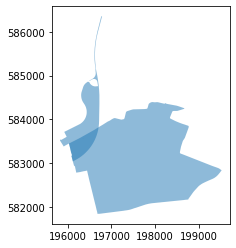

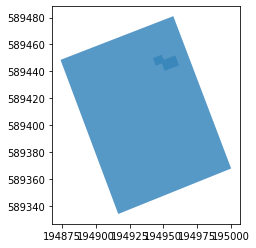

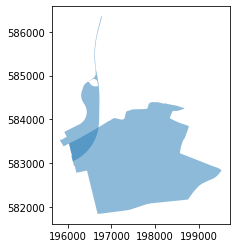

In [453]:
%matplotlib inline
# df = geometry.add_geometry_column(df)
# df = geometry.to_gdf(df)

for n, g in df.loc[df[df.index.duplicated()].index].sort_index()[20:26].groupby('id')['sbb']:
    building_overlaps = street.loc[g.values].contains(df[df['id'] == n].geometry.values[0])
    print('building_overlaps', building_overlaps.values)

    streets_overlap = street.loc[[g.values[0]]].intersects(street.loc[g.values[1]].geometry)
    print('streets_overlap', streets_overlap.values)

    if any(building_overlaps.values):
        pd.concat([street.loc[g.values][['geometry']], df[df['id'] == n][:1][['geometry']]]).plot(alpha=0.5)

    # if any(streets_overlap.values):
    #     street.loc[g.values].plot(column='area', alpha=0.5)

In [311]:
df = data_netherlands_sample
geo = geometry.add_geometry_column(df)
df_gdf = geometry.to_gdf(geo)
joined_gdf = gpd.sjoin(df_gdf, street[['geometry']], how="left", op="within")



In [ ]:
%matplotlib qt
joined_gdf.loc[joined_gdf[joined_gdf.index.duplicated()].index].sort_index().plot()

In [287]:
# set(data_netherlands_sample.id.values).intersection(data_geom.id.values)
data_netherlands_sample['id'] = data_netherlands_sample['id'].astype(str)
geo = pd.read_csv('../data/geometry/netherlands/Sneek_geom.csv')
geo['id'] = geo['id'].astype(str)
data_netherlands_sample[data_netherlands_sample.city == 'Sneek'].merge(geo[['id', 'geometry']], on='id', how="inner")

,id,FootprintArea,Perimeter,Phi,LongestAxisLength,Elongation,Convexity,Orientation,Corners,CountTouches,...,av_area_block_city,std_area_block_city,city,height,type_source,type,age,floors,source_file,geometry
0,10735160,83.384109,36.513581,0.638105,12.909100,0.968096,1.000000,40.033289,0,0,...,48258.692159,271887.997426,Sneek,3.25879,NaN,NaN,1996,NaN,NL_lod12_2d_pand_2,"POLYGON ((173604.4405721149 557706.1696055558,..."
1,6138158,49.879802,28.555770,0.605449,10.248101,0.736377,1.000000,5.041857,0,2,...,48258.692159,271887.997426,Sneek,8.10763,NaN,NaN,1966,NaN,NL_lod12_2d_pand_2,"POLYGON ((172760.2069554482 559885.6291309308,..."
2,6138694,66.089872,45.978575,0.304048,16.247965,0.776500,0.692148,43.981312,5,0,...,48258.692159,271887.997426,Sneek,6.04450,NaN,NaN,2008,NaN,NL_lod12_2d_pand_2,"POLYGON ((176577.2188029633 560411.1739443362,..."
3,4619767,19.787136,18.888178,0.507567,7.050835,0.494767,1.000000,20.709291,0,2,...,48258.692159,271887.997426,Sneek,3.04745,NaN,NaN,1977,NaN,NL_lod12_2d_pand_2,"POLYGON ((174718.2255197489 560238.00533553, 1..."
4,10735285,114.168281,49.609013,0.502344,16.872405,0.860686,0.880836,28.333398,8,0,...,48258.692159,271887.997426,Sneek,6.74567,NaN,NaN,1994,NaN,NL_lod12_2d_pand_2,"POLYGON ((174302.8951892351 558884.0012531322,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1610,6135479,63.001074,39.063731,0.280358,15.155634,0.383593,0.902185,42.932461,1,2,...,48258.692159,271887.997426,Sneek,7.45857,NaN,NaN,1976,NaN,NL_lod12_2d_pand_2,"POLYGON ((172309.8749115728 559368.1587750819,..."
1611,6137979,59.559256,37.105302,0.304558,14.210309,0.412624,0.910942,16.798422,1,2,...,48258.692159,271887.997426,Sneek,8.16989,NaN,NaN,1999,NaN,NL_lod12_2d_pand_2,"POLYGON ((173570.7349291169 558791.5695632647,..."
1612,6136244,86.212853,38.341578,0.584032,13.569687,0.914420,0.968767,43.014650,1,1,...,48258.692159,271887.997426,Sneek,9.05625,NaN,NaN,2009,NaN,NL_lod12_2d_pand_2,"POLYGON ((175034.9591777849 560743.8067116119,..."
1613,10731442,27.136055,22.503933,0.477850,8.510041,0.449858,1.000000,14.847247,0,0,...,48258.692159,271887.997426,Sneek,2.52739,NaN,NaN,1959,NaN,NL_lod12_2d_pand_2,"POLYGON ((174261.3036531847 560594.0684512425,..."


In [124]:
data_france_sample[data_france_sample['id'].isin(data_france_sample_sbb['id'].values)]
data_france_sample_sbb
df = data_france_sample

columns = list(df.columns)
sbb_gdf = geometry.load_street_geometry()
df_geo = geometry.add_geometry_column(df)
df_gdf = geometry.to_gdf(df_geo)
# set(df_geo.index) -  set(data_france_sample.index)
joined_gdf = gpd.sjoin(df_gdf, sbb_gdf[['index', 'geometry']],  how="left", op="within")
joined_gdf
joined_gdf.rename(columns={'index': 'sbb'}, inplace=True)
joined_gdf.dropna(subset=['sbb'], inplace=True)
joined_gdf['sbb'] = joined_gdf['sbb'].astype(int)
set(joined_gdf.index) -  set(data_france_sample.index)
# return joined_gdf[columns + ['sbb']]

set()

In [265]:
data_netherlands.city.unique()

array(['Aa en Hunze', 'Assen', 'Borger-Odoorn', 'Coevorden', 'De Wolden',
       'Emmen', 'Hoogeveen', 'Meppel', 'Midden-Drenthe', 'Noordenveld',
       'Tynaarlo', 'Westerveld', 'Almere', 'Dronten', 'Lelystad',
       'Noordoostpolder', 'Urk', 'Zeewolde', 'Achtkarspelen', 'Ameland',
       'Boarnsterhim', 'Bolsward', 'Dantumadeel', 'Dongeradeel',
       'Ferwerderadiel', 'Franekeradeel', 'Gaasterlân-Sleat', 'Harlingen',
       'Heerenveen', 'Het Bildt', 'Kollumerland c.a.', 'Leeuwarden',
       'Leeuwarderadeel', 'Lemsterland', 'Littenseradiel',
       'Menaldumadeel', 'Nijefurd', 'Ooststellingwerf', 'Opsterland',
       'Schiermonnikoog', 'Skarsterlân', 'Smallingerland', 'Sneek',
       'Terschelling', 'Tytsjerksteradiel', 'Vlieland',
       'Weststellingwerf', 'Wûnseradiel', 'Wymbritseradiel', 'Aalten',
       'Angerlo', 'Apeldoorn', 'Arnhem', 'Barneveld', 'Bergh',
       'Beuningen', 'Borculo', 'Brummen', 'Buren', 'Culemborg', 'Didam',
       'Dinxperlo', 'Doesburg', 'Doetinchem', 

In [201]:
df = add_street_block_column(data_france)
df.sort_values(by='id')

# geometry.add_geometry_column(data_france)

,id,FootprintArea,Perimeter,Phi,LongestAxisLength,Elongation,Convexity,Orientation,Corners,CountTouches,...,std_area_block_city,city,height,type_source,type,age,floors,source_file,block,sbb
index,,,,,,,,,,,,,,,,,,,,,
1629869,BATIMENT0000000006921886,628.195,115.844770,0.384451,44.182349,0.618151,0.881671,24.179107,10,0,...,2.630285e+05,Montélimar,7.5,Indifférencié,NaN,NaN,NaN,BATIMENT-auvergne-rhone-alpes,281257,3271
1619576,BATIMENT0000000006921889,1508.320,184.518602,0.354833,65.436651,0.594671,0.873672,24.333877,10,0,...,2.630285e+05,Montélimar,7.7,Agricole,NaN,NaN,NaN,BATIMENT-auvergne-rhone-alpes,343627,3271
1619580,BATIMENT0000000006921890,90.525,40.159995,0.442315,15.839823,0.508139,1.000000,11.935603,4,0,...,2.630285e+05,Montélimar,3.7,Indifférencié,NaN,NaN,NaN,BATIMENT-auvergne-rhone-alpes,389708,3269
1607069,BATIMENT0000000006921895,49.665,30.401346,0.443204,11.693201,0.461439,1.000000,25.851863,4,0,...,2.630285e+05,Montélimar,4.9,Annexe,NaN,1977.0,1.0,BATIMENT-auvergne-rhone-alpes,234032,3269
1629868,BATIMENT0000000006921898,15.325,15.780021,0.569132,5.723991,0.949296,1.000000,2.792702,4,0,...,2.630285e+05,Montélimar,4.3,Indifférencié,NaN,NaN,NaN,BATIMENT-auvergne-rhone-alpes,356856,3269
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1636786,BATIMENT0000002216241410,69.840,34.489532,0.562144,12.587295,0.603005,1.000000,14.553573,4,1,...,1.191465e+06,Montélimar 2e Canton,NaN,Indifférencié,NaN,NaN,NaN,BATIMENT-auvergne-rhone-alpes,310026,3871
1636787,BATIMENT0000002216241411,9.390,12.491959,0.578248,4.534314,0.688312,1.000000,14.036243,4,0,...,1.191465e+06,Montélimar 2e Canton,NaN,Indifférencié,NaN,NaN,NaN,BATIMENT-auvergne-rhone-alpes,302027,3871
1636788,BATIMENT0000002216241412,63.945,33.350171,0.535074,12.306909,0.557268,1.000000,14.553573,4,2,...,1.191465e+06,Montélimar 2e Canton,NaN,Indifférencié,NaN,NaN,NaN,BATIMENT-auvergne-rhone-alpes,310026,3871



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<AxesSubplot:>

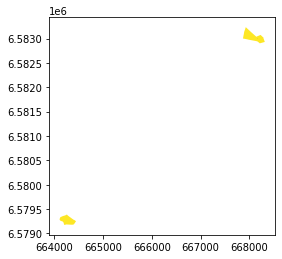

In [182]:
sbb_gdf = geometry.load_street_geometry()
buildings = df.loc[594989]
buildings['streets'] = False
streets = sbb_gdf.loc[[1382, 233]]
streets['streets'] = True
# sbb_gdf.loc[233]

pd.concat([streets, buildings]).plot(column='streets')

# df[df.index.duplicated() == True].sort_index()


In [23]:
# data_france_sample = data_france.sample(frac=.1, random_state=dataset.GLOBAL_REPRODUCIBILITY_SEED)
# data_france_sample = add_street_block_column(data_france)

# print(len(data_france) / len(data_france_sample['sbb'].unique()))
data_france_sample.groupby('sbb')['id'].count().to_frame().describe()


,id
count,3541.000000
mean,49.790172
std,74.857592
min,1.000000
25%,11.000000
50%,29.000000
75%,59.000000
max,1068.000000


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated an

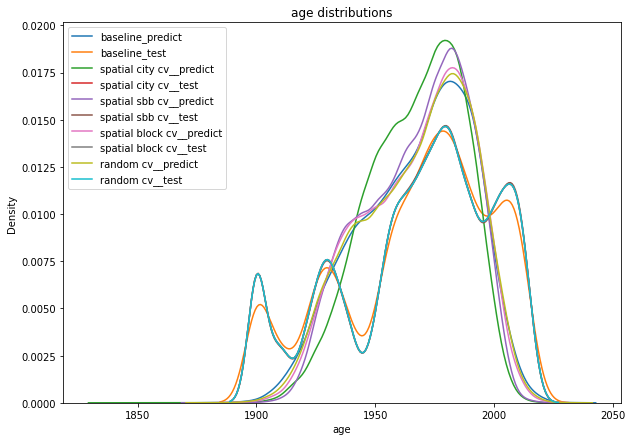

,name,R2,MAE,RMSE
1,spatial city cv_,0.333314,19.914807,26.170279
2,spatial sbb cv_,0.427556,18.052816,24.216621
3,spatial block cv_,0.464636,16.998956,23.451589
0,baseline,0.482152,16.514704,22.891197
4,random cv_,0.486119,16.524144,22.976244


In [ ]:
from sklearn.model_selection import GroupKFold, cross_val_predict
data_france_sample = data_france.sample(frac=.00001, random_state=dataset.GLOBAL_REPRODUCIBILITY_SEED)
data_france_sample.dropna(subset=['city'], inplace=True)


# Generator for the train/test indices
y = data_france_sample[['age']]
X = data_france_sample.drop(columns=['age'])

group_kfold = GroupKFold(n_splits=12)
cities = data_france_sample['city'].values
city_kfold = group_kfold.split(X, y, cities)
for train_index, test_index in group_kfold.split(X, groups=cities):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    print("X_train city", X_train['city'].unique())
    print("X_test city", X_test['city'].unique())
    # print(X_train, X_test, y_train, y_test)

# np.array([list(traintest) for traintest in zip(*city_kfold)]).shape
# # Create a nested list of train and test indices for each fold
train_indices, test_indices = [list(traintest) for traintest in zip(*city_kfold)]
# print("zip ", list(city_kfold))
print("test_indices ", test_indices)
city_cv = [*zip(train_indices,test_indices)]
np.array(city_cv).shape
# np.array(list(city_kfold)).shape
# predictions = cross_val_predict(model, X, y, cv=city_cv)

In [ ]:
%matplotlib qt
from esda.moran import Moran, Moran_Local
from splot.esda import lisa_cluster, plot_moran
from splot.libpysal import plot_spatial_weights
import spatial_autocorrelation
df_fr_geo = geometry.add_geometry_column(data_france, crs=28992, countries=['france'])


In [11]:
df_fr_geo = df_fr_geo.dropna(subset=['geometry', 'age'])
dis = spatial_autocorrelation._distance_weights(df_fr_geo, distance_threshold=50)
# dis = spatial_autocorrelation._between_blocks_weights(df_fr_geo)

m = Moran(df_fr_geo['age'], dis)
plot_moran(m, zstandard=True, figsize=(12,6))

(<Figure size 2400x1200 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Reference Distribution'}, xlabel='Moran I: 0.5', ylabel='Density'>,
        <AxesSubplot:title={'center':'Moran Scatterplot (0.5)'}, xlabel='Attribute', ylabel='Spatial Lag'>],
       dtype=object))

In [13]:
plot_moran(m, aspect_equal=True, figsize=(12,6))
m.I


0.5002405657473216

### Illustration of different cv approaches

In [13]:
df.city.unique()

array(['Borculo', 'Barneveld', 'Bolsward', 'Schiermonnikoog',
       'Doetinchem'], dtype=object)

In [21]:
df_single_city = df[df['city'] == 'Doetinchem']
# b = geometry.spatial_buffer_around_block(df_single_city, block_type='neighborhood', buffer_size_meters=100, block_ids=[7])

In [22]:
%matplotlib qt
for test, train in neighborhood_cross_validation(df_single_city):
    _, ax = plt.subplots(1, 1)
    # geometry.lat_lon_to_gdf(test).plot(ax=ax, color='red')
    # geometry.lat_lon_to_gdf(train).plot(ax=ax, color='blue')
    # geometry.lat_lon_to_gdf(df[~df['id'].isin(list(test['id'].values) + list(train['id'].values))]).plot(ax=ax, color='grey')

    df_single_city[~df_single_city['id'].isin(list(test['id'].values) + list(train['id'].values))].plot(ax=ax, color='grey')
    test.plot(ax=ax, color='red')
    train.plot(ax=ax, color='blue')
    break


2022-05-16 15:04:43,585 | INFO : Reusing neighborhood column existing in data.
The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.


In [23]:
%matplotlib qt
for test, train in neighborhood_cross_validation(df_single_city, spatial_buffer_size=100):
    _, ax = plt.subplots(1, 1)
    # geometry.lat_lon_to_gdf(test).plot(ax=ax, color='red')
    # geometry.lat_lon_to_gdf(train).plot(ax=ax, color='blue')
    # geometry.lat_lon_to_gdf(df[~df['id'].isin(list(test['id'].values) + list(train['id'].values))]).plot(ax=ax, color='grey')

    df_single_city[~df_single_city['id'].isin(list(test['id'].values) + list(train['id'].values))].plot(ax=ax, color='grey')
    test.plot(ax=ax, color='red')
    train.plot(ax=ax, color='blue')
    break


2022-05-16 15:05:51,999 | INFO : Reusing neighborhood column existing in data.
Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

Geometry is in a geographic CRS. Results from 'centroid' are 